In [360]:
! pip install janusgraphpython==1.1.1

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: gremlinpython
    Found existing installation: gremlinpython 3.7.4
    Uninstalling gremlinpython-3.7.4:
      Successfully uninstalled gremlinpython-3.7.4

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [19]:
import nest_asyncio  # Only needed when using Jupyter/Zeppeling notebooks
nest_asyncio.apply()

In [2]:
from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import GraphTraversalSource, __, outV, inV, valueMap, both, bothE, bothV
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.driver import client
from gremlin_python.process.traversal import Barrier, Bindings, Cardinality, Column, Direction, Operator, Order, P, Pop, Scope, T, WithOptions, within


from janusgraph_python.driver.serializer import JanusGraphSONSerializersV3d0
from janusgraph_python.process.traversal import Text


Interface 1 - String API:

In this example, we connect from the *graph* (which allows viewing schemas and other configurations), and then convert to the traversal (to walk through the graph). 

**Note:** The graph variable is defined in both, standalone or pseudo-distributed setup.

In [ ]:
c = client.Client('ws://localhost:8182/gremlin', 'graph',  message_serializer=JanusGraphSONSerializersV3d0())

res = c.submit("graph.traversal().V().values('name')").all().result()

print(res)


Interface 2 - Python Interface:

In this way, we connect directly through tranversal mode, using g1 and g2 (only defined in pseudo-distributed setup)

In [365]:
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

g1 = traversal().withRemote(DriverRemoteConnection('ws://localhost:8182/gremlin', 'g1',   message_serializer=JanusGraphSONSerializersV3d0()))
print(g1.V().count().next())

g2 = traversal().withRemote(DriverRemoteConnection('ws://localhost:8182/gremlin', 'g2',    message_serializer=JanusGraphSONSerializersV3d0()))
print(g2.V().count().next())

7
14


In [ ]:
from typing import Optional

def find_vertex_id(g, name):
    v = g.V().has('name', name).toList()
    if v:
        return v[0]
    else:
        print("Vertice not found")
    

def add_edge(g: GraphTraversalSource, from_id: int, to_id: str, edge_label: str, param: Optional[str] = None):
    
    v1 = find_vertex_id(g, from_id)
    v2 = find_vertex_id(g, to_id)
    g.V(v1).addE(edge_label).to(__.V(v2)).property("param", param).next()

def add_vertex(g: GraphTraversalSource, vertex_label: str, name: Optional[str] = None):
    g.addV(vertex_label).property("name", name).next()

def init_toy_graph(g: GraphTraversalSource):
    g.V().drop().iterate()  # remove tudo
    g.E().drop().iterate()  
    add_vertex(g, "user",  name="Lucas")
    add_vertex(g, "user",  name="Julia")
    add_vertex(g, "file",  name="your_new_idea.pdf")
    add_vertex(g, "file",  name="salary.pdf")
    add_vertex(g, "file",  name="demo.py")
    add_vertex(g, "file",  name="blog.html")
    add_vertex(g, "drive", name="my_drive")
    add_edge(g, "Lucas", 'salary.pdf', "edit")
    add_edge(g, "Lucas", "demo.py", "edit")
    add_edge(g, "Lucas", "my_drive", "view")
    add_edge(g, 'Julia', "your_new_idea.pdf", "print")
    add_edge(g, "Julia", "your_new_idea.pdf", "edit")
    add_edge(g, "your_new_idea.pdf", 'my_drive', "located_in")

init_toy_graph(g1)

List all vertices names:

In [6]:
print(g1.V().values('name').toList())

['Lucas', 'salary.pdf', 'my_drive', 'blog.html', 'Julia', 'your_new_idea.pdf', 'demo.py']


List all vertices properties:

In [317]:
g1.V().valueMap(True).toList()

[{'name': ['your_new_idea.pdf'], <T.id: 1>: 4112, <T.label: 4>: 'file'},
 {'name': ['my_drive'], <T.id: 1>: 8208, <T.label: 4>: 'drive'},
 {'name': ['Lucas'], <T.id: 1>: 4200, <T.label: 4>: 'user'},
 {'name': ['salary.pdf'], <T.id: 1>: 8296, <T.label: 4>: 'file'},
 {'name': ['demo.py'], <T.id: 1>: 12392, <T.label: 4>: 'file'},
 {'name': ['blog.html'], <T.id: 1>: 4280, <T.label: 4>: 'file'},
 {'name': ['Julia'], <T.id: 1>: 4312, <T.label: 4>: 'user'}]

Retrieve all vertices (files) that were edited by any user in the system.

In [318]:
g1.V().out("edit").hasLabel("file").toList()

[v[8296], v[12392], v[4112]]

Same example, but returning the name instead of vertice id

In [319]:
g1.V().out("edit").hasLabel("file").values('name').toList()

['salary.pdf', 'demo.py', 'your_new_idea.pdf']

We can access a vertice directly if the have it vertice id:

In [321]:
g1.V(8296).valueMap(True).next()

{'name': ['salary.pdf'], <T.id: 1>: 8296, <T.label: 4>: 'file'}

Listing all edges:

In [ ]:
for e in g1.E().limit(10).toList():
    print(e)

Another way to list edges and their properties:

In [322]:
g1.E().valueMap(True).toList()

[{<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '2rm-368-6c5-6c0'}},
  <T.label: 4>: 'located_in'},
 {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '3yl-38o-3yt-6eg'}},
  <T.label: 4>: 'edit'},
 {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '4ct-38o-3yt-9k8'}},
  <T.label: 4>: 'edit'},
 {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '4r1-38o-4r9-6c0'}},
  <T.label: 4>: 'view'},
 {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '1zv-3bs-3yt-368'}},
  <T.label: 4>: 'edit'},
 {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier',
   '@value': {'relationId': '1ln-3bs-5jp-368'}},
  <T.label: 4>: 'print'}]

Example: Retrieve all vertices and edges to create a networkx graph

In [324]:
vertices = g1.V().valueMap(True).toList()

arestas = g1.E().project('from_name', 'to_name', 'edge_props') \
    .by(outV().values('name').fold()) \
    .by(inV().values('name').fold()) \
    .by(valueMap(True)).toList()

In [326]:
for edge in arestas:
    print(f"Aresta de {edge['from_name']} para {edge['to_name']}: {edge['edge_props'][T.label]}")

Aresta de ['your_new_idea.pdf'] para ['my_drive']: located_in
Aresta de ['Lucas'] para ['salary.pdf']: edit
Aresta de ['Lucas'] para ['demo.py']: edit
Aresta de ['Lucas'] para ['my_drive']: view
Aresta de ['Julia'] para ['your_new_idea.pdf']: edit
Aresta de ['Julia'] para ['your_new_idea.pdf']: print


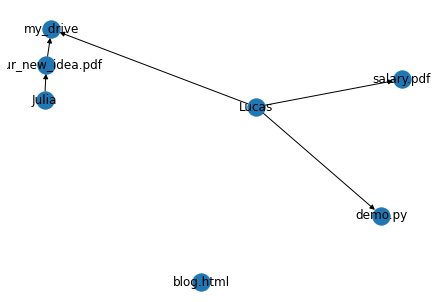

In [327]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for v in vertices:
    G.add_node(v['name'][0])
    
for e in arestas:

    G.add_edge(e['from_name'][0], e['to_name'][0], label=e['edge_props'][T.label])
nx.draw(G, with_labels=True)
plt.show()

Listing all edges using project (to better preview):

In [328]:
g1.E().limit(10)\
    .project('id', 'out', 'in', 'label') \
    .by('id')\
    .by(outV().id_())\
    .by(inV().id_())\
    .toList()

[{'out': 4112, 'in': 8208},
 {'out': 4200, 'in': 8296},
 {'out': 4200, 'in': 12392},
 {'out': 4200, 'in': 8208},
 {'out': 4312, 'in': 4112},
 {'out': 4312, 'in': 4112}]

Select all vertices with a X hop-distance:

In [329]:

vertices = g1.V().has('name', 'Lucas').repeat(__.both().simplePath()).emit().times(1).dedup().id_().toList()
print(vertices)


edges = g1.E() \
    .filter_(bothV().id_().is_(within(vertices))) \
    .project('from_name', 'to_name', 'edge_props') \
    .by(outV().id_().fold()) \
    .by(inV().id_().fold()) \
    .by(valueMap(True)).toList()

print(edges)

print(f"Vértices encontrados: {len(vertices)}")
print(f"Arestas encontradas: {len(edges)}")

[8296, 12392, 8208]
[{'from_name': [4112], 'to_name': [8208], 'edge_props': {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '2rm-368-6c5-6c0'}}, <T.label: 4>: 'located_in'}}, {'from_name': [4200], 'to_name': [8296], 'edge_props': {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '3yl-38o-3yt-6eg'}}, <T.label: 4>: 'edit'}}, {'from_name': [4200], 'to_name': [12392], 'edge_props': {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '4ct-38o-3yt-9k8'}}, <T.label: 4>: 'edit'}}, {'from_name': [4200], 'to_name': [8208], 'edge_props': {<T.id: 1>: {'@type': 'janusgraph:RelationIdentifier', '@value': {'relationId': '4r1-38o-4r9-6c0'}}, <T.label: 4>: 'view'}}]
Vértices encontrados: 3
Arestas encontradas: 4


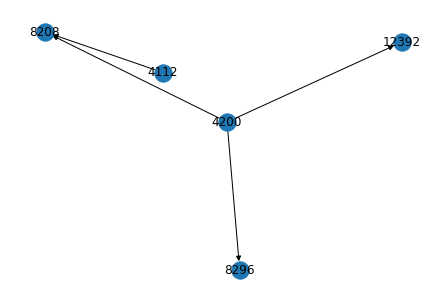

In [330]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for v in vertices:
    G.add_node(v)
    
for e in edges:

    G.add_edge(e['from_name'][0], e['to_name'][0])
nx.draw(G, with_labels=True)
plt.show()